In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid', context='talk', palette='colorblind')

## Keywords

In [2]:
df = pd.read_csv('paperlist.tsv', index_col=0, sep='\t')
print('# papers:', len(df))
df.head()

# papers: 2966


,title,link,keywords,abstract
paper_id,,,,
1Fqg133qRaI,Towards Faster and Stabilized GAN Training for...,https://openreview.net/forum?id=1Fqg133qRaI,"deep learning, generative model, image synthes...",Training Generative Adversarial Networks (GAN)...
VVdmjgu7pKM,Factorizing Declarative and Procedural Knowled...,https://openreview.net/forum?id=VVdmjgu7pKM,"procedural knowledge, declarative knowledge, S...","Modeling a structured, dynamic environment lik..."
-Lr-u0b42he,Disentangling 3D Prototypical Networks for Few...,https://openreview.net/forum?id=-Lr-u0b42he,"Disentanglement, Few Shot Learning, 3D Vision,...",We present neural architectures that disentang...
dKwmCtp6YI,Representation and Bias in Multilingual NLP: I...,https://openreview.net/forum?id=dKwmCtp6YI,"multilinguality, science for NLP, fundamental ...",Inspired by the phenomenon of performance disp...
WoLQsYU8aZ,PettingZoo: Gym for Multi-Agent Reinforcement ...,https://openreview.net/forum?id=WoLQsYU8aZ,"Reinforcement Learning, Multi-agent Reinforcem...","OpenAI's Gym library contains a large, divers..."


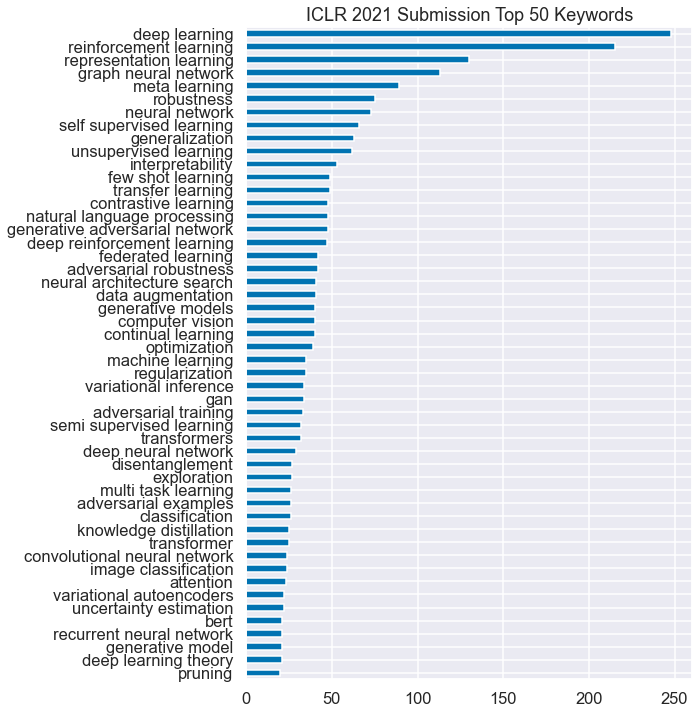

In [3]:
counts = pd.Series(
    ', '.join(df['keywords'].dropna()).lower().replace('-', ' ').replace('networks', 'network').split(',')
).str.strip().value_counts().sort_values(ascending=True)
counts.iloc[-50:].plot.barh(figsize=(8, 12), title='ICLR 2021 Submission Top 50 Keywords')
plt.savefig('asset/keywords.png', dpi=300, bbox_inches='tight')

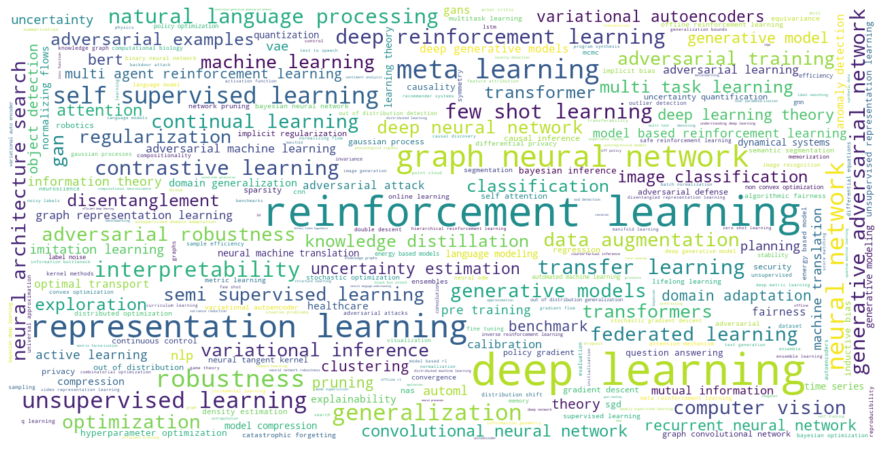

In [4]:
from imageio import imread
from wordcloud import WordCloud

wc = WordCloud(background_color="white", max_words=300, max_font_size=64, 
               width=1280, height=640, random_state=0)
wc.generate_from_frequencies(counts.to_dict())
fig = plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig('asset/wordcloud.png', dpi=300, bbox_inches='tight')

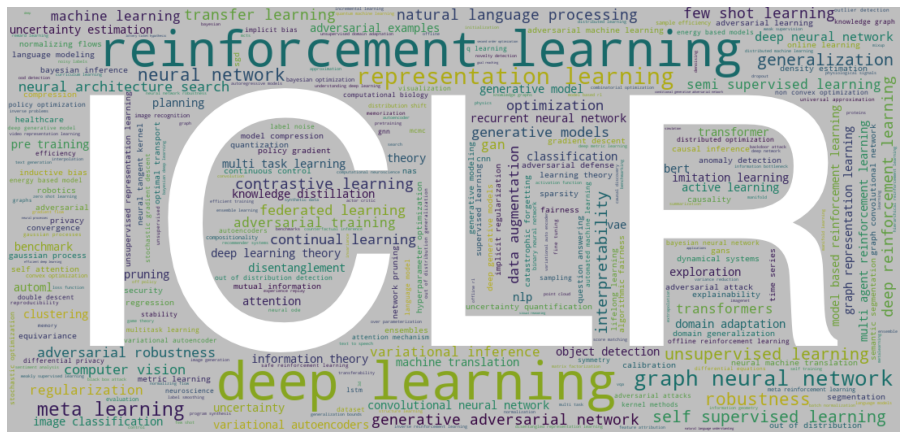

In [5]:
from imageio import imread
from wordcloud import WordCloud

logo = imread('asset/logo.png')
wc = WordCloud(background_color="white", max_words=300, max_font_size=64, 
               width=1280, height=640, random_state=0, mask=logo)
wc.generate_from_frequencies(counts.to_dict())
fig = plt.figure(figsize=(16, 8))
plt.imshow(logo)
plt.imshow(wc, interpolation="bilinear", alpha=.75)
plt.axis("off")
plt.savefig('asset/logo_wordcloud.png', dpi=300, bbox_inches='tight')

## Rating Distributions

In [6]:
ratings = pd.read_csv('ratings.tsv', sep='\t', index_col=0)
print(ratings.iloc[:, :-1].stack().mean())
ratings.head()

5.367359413202934


,0,1,2,3,4,5,decision
paper_id,,,,,,,
1Fqg133qRaI,7.0,7.0,7.0,7.0,NaN,NaN,Accept (Poster)
VVdmjgu7pKM,5.0,6.0,8.0,7.0,NaN,NaN,Accept (Poster)
-Lr-u0b42he,7.0,5.0,6.0,6.0,NaN,NaN,Accept (Poster)
dKwmCtp6YI,3.0,4.0,5.0,6.0,NaN,NaN,Reject
WoLQsYU8aZ,3.0,6.0,5.0,7.0,NaN,NaN,Reject


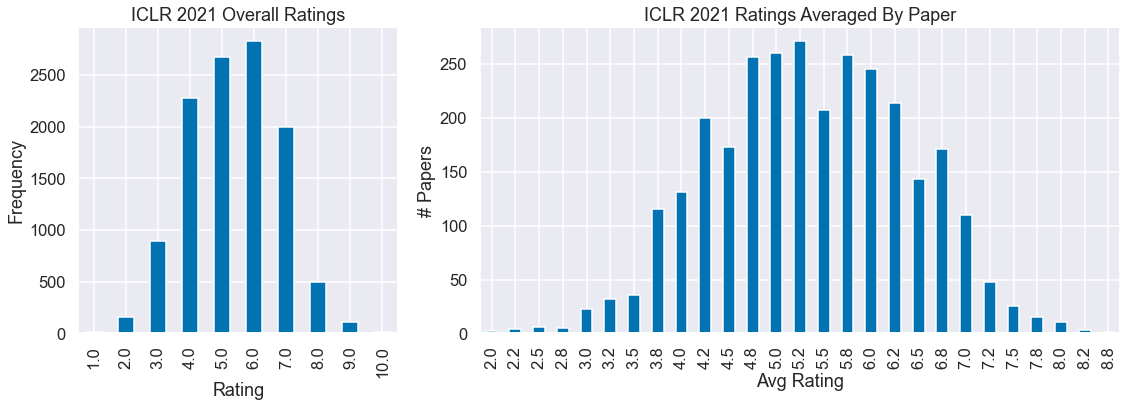

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 2]})
ratings.iloc[:, :-1].stack().value_counts().sort_index().plot.bar(
    ax=axes[0], title='ICLR 2021 Overall Ratings', xlabel='Rating', ylabel='Frequency')
ratings.iloc[:, :-1].mean(axis=1).mul(4).round().div(4).round(1).value_counts().sort_index().plot.bar(
    ax=axes[1], title='ICLR 2021 Ratings Averaged By Paper', xlabel='Avg Rating', ylabel='# Papers')
plt.tight_layout()
plt.savefig('asset/ratings_dist.png', dpi=300, bbox_inches='tight')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


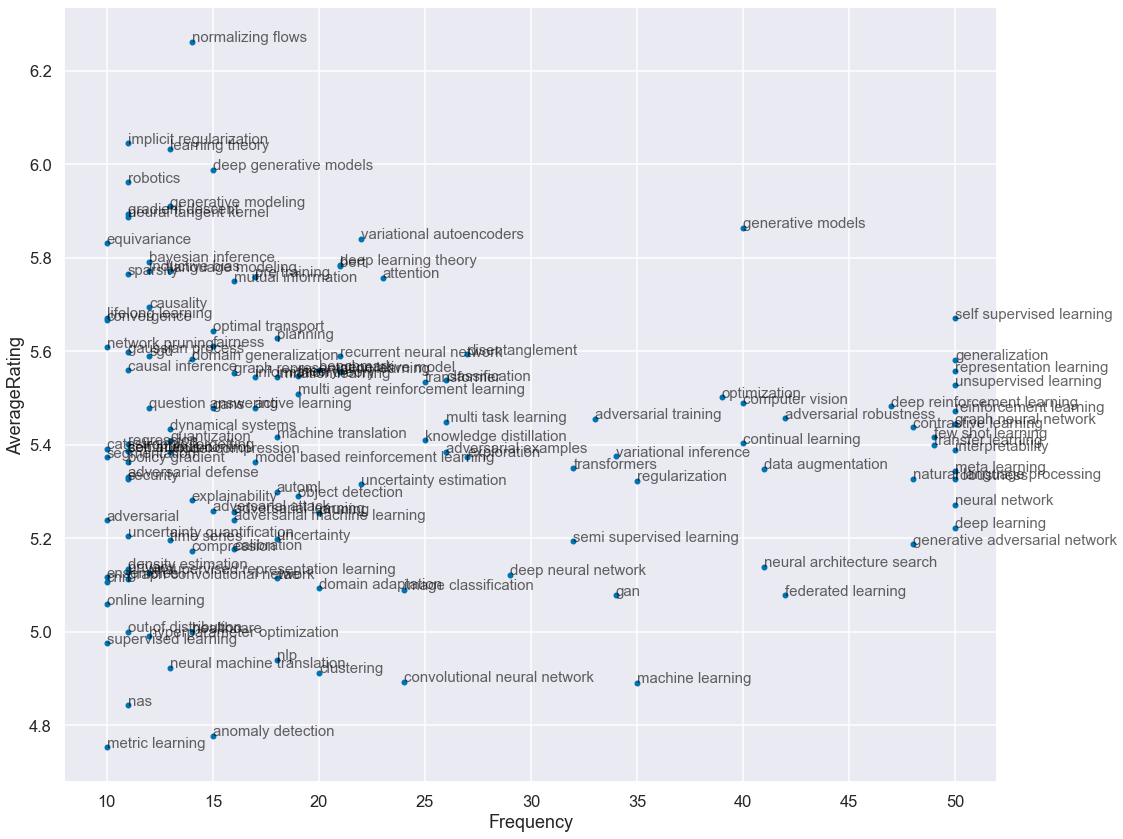

In [8]:
data = {}
for keywords, rating in zip(df.keywords, ratings.iloc[:, :-1].mean(axis=1)):
    if (isinstance(keywords, float) and np.isnan(keywords)) or np.isnan(rating):
        continue
    for keyword in keywords.lower().replace('-', ' ').replace('networks', 'network').split(','):
        data.setdefault(keyword.strip(), []).append(rating)

t = pd.DataFrame({
    'Frequency': [min(len(v), 50) for v in data.values()], # clip to 50
    'AverageRating': [np.mean(v) for v in data.values()],
    'Keyword': list(data.keys())
}).query('Frequency>9')
t.plot.scatter(x='Frequency', y='AverageRating', figsize=(16, 12))

for i in range(len(t)):
     plt.text(t.Frequency.iloc[i], t.AverageRating.iloc[i], t.Keyword.iloc[i], 
              horizontalalignment='left', 
              size='small', color='black', alpha=0.6)

plt.tight_layout()
plt.savefig('asset/keyword_ratings.png', dpi=300, bbox_inches='tight')

## Top 50 Papers

In [9]:
comb_df = pd.DataFrame({
    'AvgRating': ratings.iloc[:, :-1].mean(axis=1).round(2),
    'Title': '[' + df['title'] + ']' + '(' + df['link'] + ')',
    'Ratings': ratings.iloc[:, :-1].apply(lambda x: ', '.join(x.dropna().astype(int).astype(str).values), axis=1),
    'Decision': ratings.iloc[:, -1],
})

comb_df = comb_df.sort_values('AvgRating', ascending=False).reset_index(drop=True)
comb_df.index += 1
comb_df.index.name = 'Rank'
comb_df.head(50)

,AvgRating,Title,Ratings,Decision
Rank,,,,
1,8.75,[How Neural Networks Extrapolate: From Feedfor...,"9, 9, 9, 8",Accept (Oral)
2,8.33,[Dataset Condensation with Gradient Matching](...,"8, 9, 8",Accept (Oral)
3,8.25,[Learning Flexible Visual Representations via ...,"9, 8, 8, 8",Accept (Oral)
4,8.25,[Towards Nonlinear Disentanglement in Natural ...,"7, 9, 8, 9",Accept (Oral)
5,8.00,[Deformable DETR: Deformable Transformers for ...,"9, 8, 8, 7",Accept (Oral)
6,8.00,[Learning a Latent Simplex in Input Sparsity T...,"7, 9, 8",Accept (Spotlight)
7,8.00,[Augmenting Physical Models with Deep Networks...,"9, 7, 8",Accept (Oral)
8,8.00,[What Matters for On-Policy Deep Actor-Critic ...,"7, 9, 9, 7",Accept (Oral)
9,8.00,[Parameterization of Hypercomplex Multiplicati...,"8, 8, 8",Accept (Spotlight)


In [10]:
# with open('ranked_papers.md', 'w', encoding='utf8') as f:
#     comb_df.to_markdown(f)